In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!kaggle datasets download -d soumikrakshit/lol-dataset

import zipfile
zip_ref = zipfile.ZipFile('/content/lol-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/lol-dataset
License(s): unknown
 99% 328M/331M [00:15<00:00, 24.7MB/s]
100% 331M/331M [00:15<00:00, 22.8MB/s]


In [ ]:
import os
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Input
from keras.models import Model
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.utils import image_dataset_from_directory

In [ ]:
# Function to load images and create datasets
def load_image_pairs(low_folder, high_folder, img_size):
    low_images = []
    high_images = []
    for filename in os.listdir(low_folder):
        low_img_path = os.path.join(low_folder, filename)
        high_img_path = os.path.join(high_folder, filename)

        if os.path.exists(high_img_path):
            low_img = load_img(low_img_path, target_size=img_size)
            high_img = load_img(high_img_path, target_size=img_size)

            low_img = img_to_array(low_img) / 255.0
            high_img = img_to_array(high_img) / 255.0

            low_images.append(low_img)
            high_images.append(high_img)

    return np.array(low_images), np.array(high_images)

In [ ]:
train_low, train_high = load_image_pairs('/content/lol_dataset/train/low', '/content/lol_dataset/train/high', (256, 256))
test_low, test_high = load_image_pairs('/content/lol_dataset/test/low', '/content/lol_dataset/test/high', (256, 256))

train_ds = tf.data.Dataset.from_tensor_slices((train_low, train_high)).batch(32)
validation_ds = tf.data.Dataset.from_tensor_slices((test_low, test_high)).batch(32)


In [ ]:
# Define the model architecture
input_shape = (256, 256, 3)
input_img = Input(shape=input_shape)

# Encoder

x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)

# Decoder
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

# Output Layer
output_img = Conv2D(3, (3, 3), padding='same', activation='tanh')(x)


In [ ]:
model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
model.fit(train_ds, validation_data=validation_ds, epochs=50)

# Save the trained model
model.save('/content/trained_model.h5')

Epoch 1/50
16/16 [==============================] - 15s 291ms/step - loss: 0.2989 - accuracy: 0.4320 - val_loss: 1.6537 - val_accuracy: 0.1252
Epoch 2/50
16/16 [==============================] - 2s 115ms/step - loss: 0.1403 - accuracy: 0.5144 - val_loss: 1.6574 - val_accuracy: 0.4989
Epoch 3/50
16/16 [==============================] - 2s 119ms/step - loss: 0.0898 - accuracy: 0.4978 - val_loss: 1.3577 - val_accuracy: 0.1375
Epoch 4/50
16/16 [==============================] - 2s 120ms/step - loss: 0.0668 - accuracy: 0.4563 - val_loss: 1.2738 - val_accuracy: 0.1442
Epoch 5/50
16/16 [==============================] - 2s 115ms/step - loss: 0.0554 - accuracy: 0.4664 - val_loss: 1.2666 - val_accuracy: 0.1727
Epoch 6/50
16/16 [==============================] - 2s 116ms/step - loss: 0.0658 - accuracy: 0.4288 - val_loss: 0.3401 - val_accuracy: 0.1643
Epoch 7/50
16/16 [==============================] - 2s 125ms/step - loss: 0.0599 - accuracy: 0.4164 - val_loss: 0.0904 - val_accuracy: 0.4923
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 291ms/step
Average PSNR: 15.13


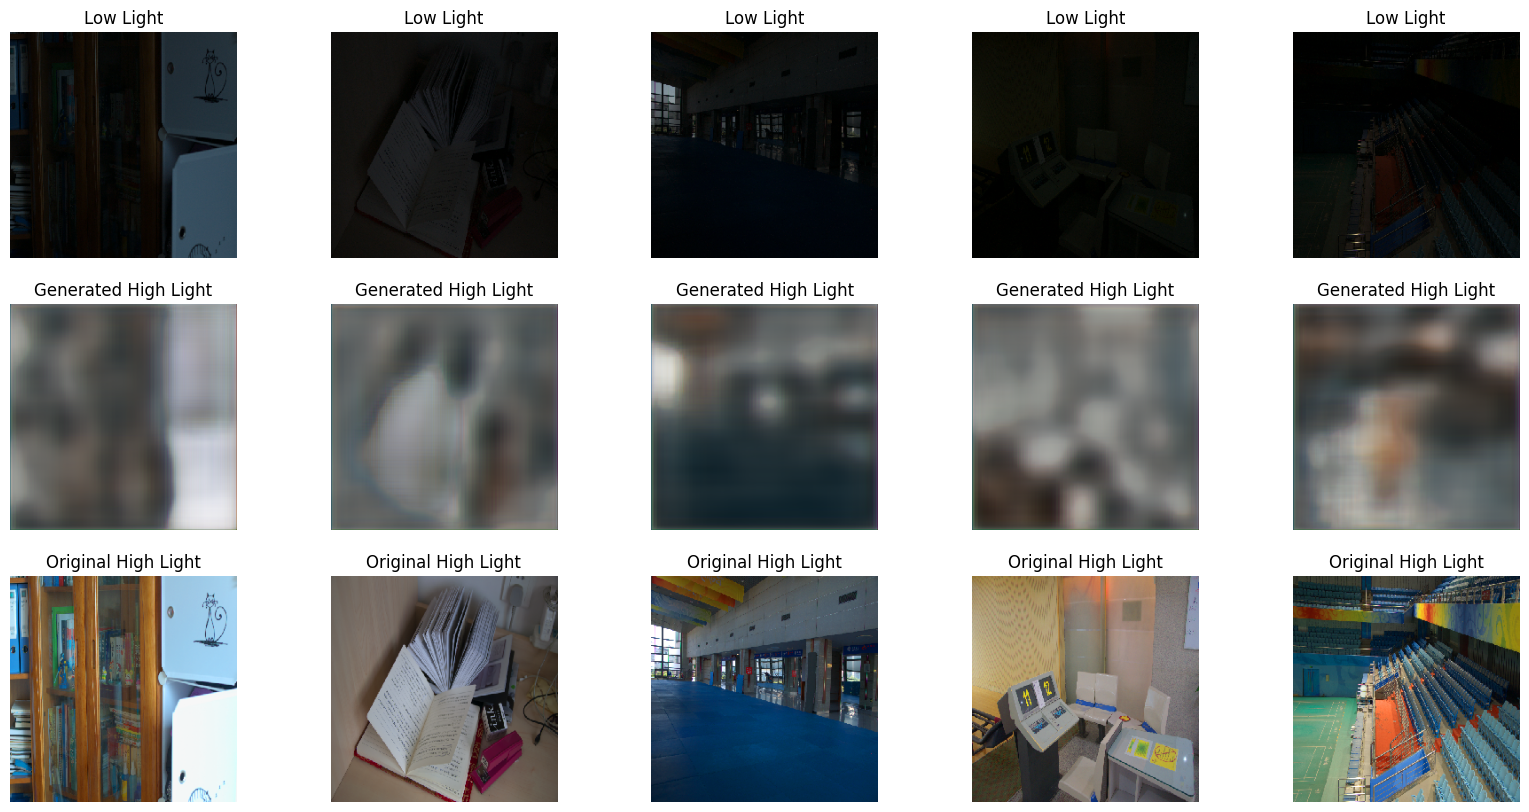

In [ ]:
model = tf.keras.models.load_model('/content/trained_model.h5')
# Function to calculate PSNR for a batch of images
def calculate_psnr(original, generated):
    psnr_scores = []
    for i in range(len(original)):
        score = psnr(original[i], generated[i], data_range=1.0)
        psnr_scores.append(score)
    return np.mean(psnr_scores)

# Generate predictions and calculate PSNR
def evaluate_model(model, low_images, high_images):
    predictions = model.predict(low_images)
    average_psnr = calculate_psnr(high_images, predictions)
    return predictions, average_psnr

# Evaluate the model on the test dataset
predictions, average_psnr = evaluate_model(model, test_low, test_high)
print(f'Average PSNR: {average_psnr:.2f}')

# Save the generated images
output_dir = './test/predicted/'
os.makedirs(output_dir, exist_ok=True)

for i, img in enumerate(predictions):
    save_img(os.path.join(output_dir, f'predicted_{i}.png'), img)

# Visualize some results
def display_results(low_images, high_images, generated_images, num_images=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(low_images[i])
        plt.title("Low Light")
        plt.axis("off")

        ax = plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(generated_images[i])
        plt.title("Generated High Light")
        plt.axis("off")

        ax = plt.subplot(3, num_images, 2*num_images + i + 1)
        plt.imshow(high_images[i])
        plt.title("Original High Light")
        plt.axis("off")
    plt.show()

# Display some results
display_results(test_low, test_high, predictions)